# API access to napari-convpaint

This notebooks demonstrates how to run the software behing the napari-convpaint plugin completely independently from napari itself.


In [1]:
%load_ext autoreload
%autoreload 2

import napari
from napari_convpaint.conv_paint import ConvPaintWidget
from napari_convpaint.conv_paint_utils import Hookmodel
from napari.utils.notebook_display import nbscreenshot
from napari_convpaint.convpaint_sample import create_annotation_cell3d
 
import numpy as np
import skimage
import tifffile

## Load data

First we load an image and the corresponding annotation. We simply display the result as a napari screenshot.

In [2]:
image = skimage.data.cells3d()
image = image[30,1]
labels = create_annotation_cell3d()[0][0]

image = image[60:188, 0:128]
labels = labels[60:188, 0:128]

In [3]:
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(labels);

This are the data we are working with:

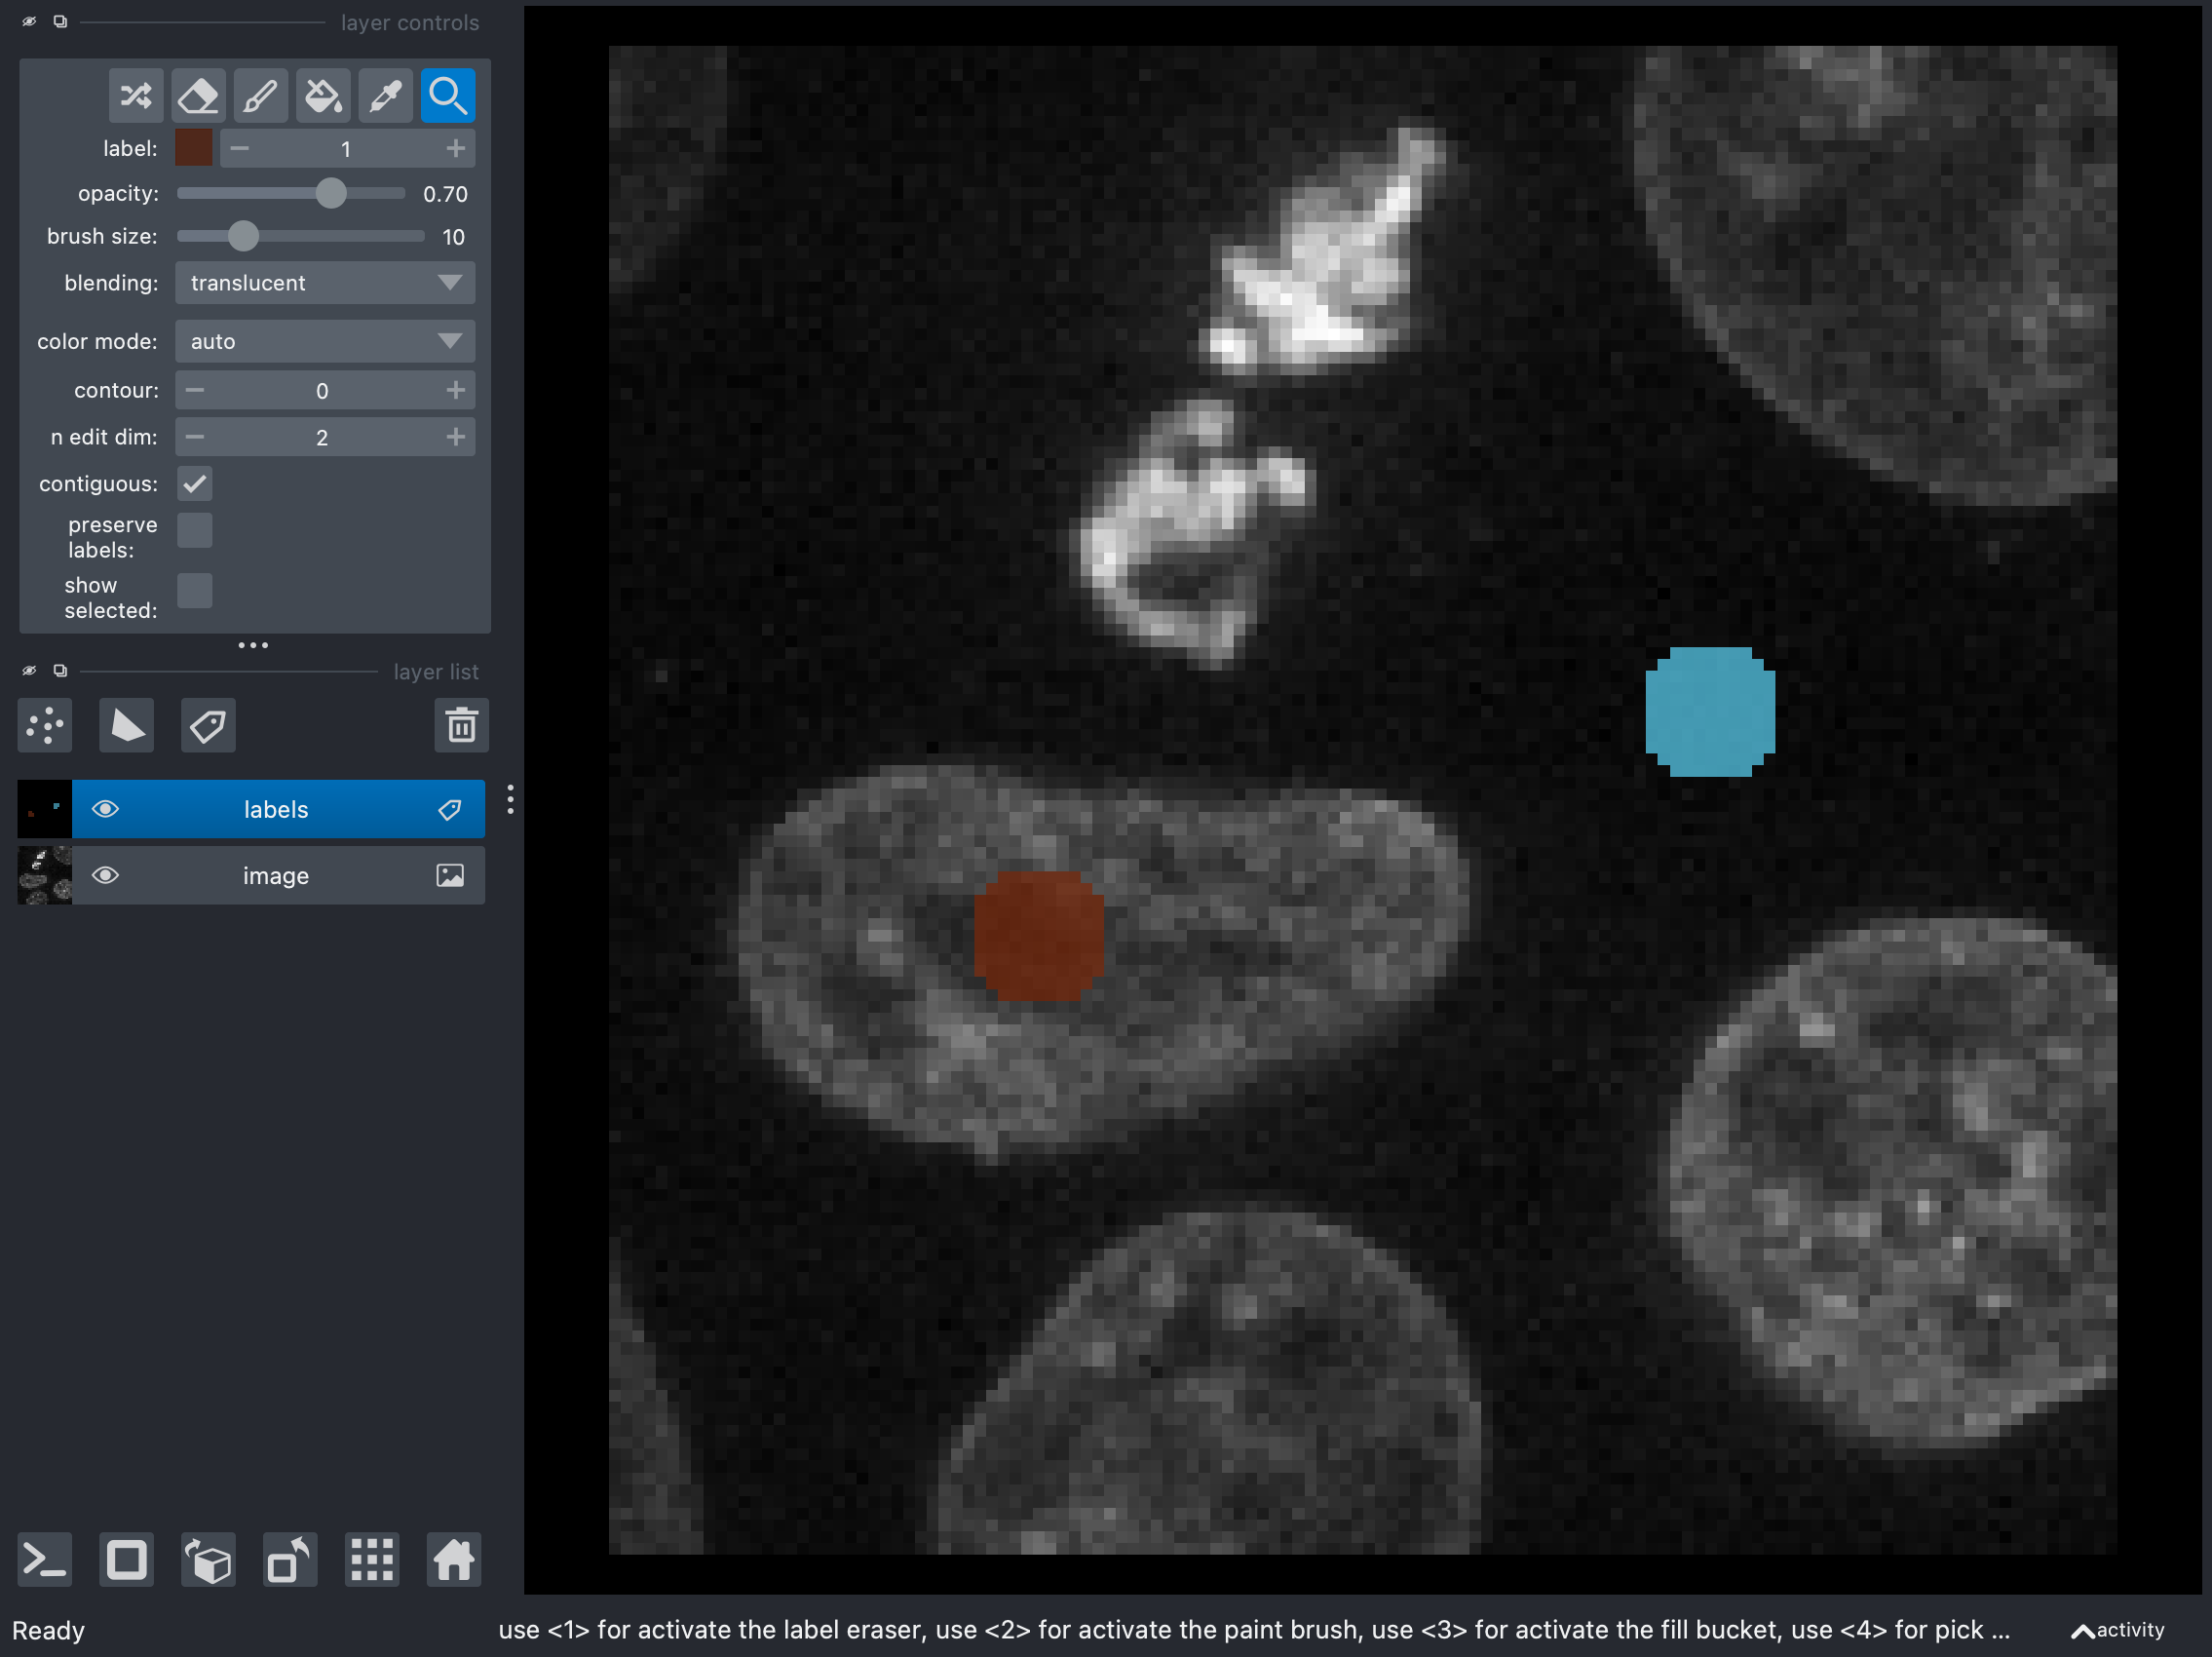

In [4]:
nbscreenshot(viewer)

In [5]:
#tifffile.imwrite('label_cell3d.tiff', viewer.layers['Labels'].data)

## Create model

The Hookmodel is a wrapper around PyTorch models. It allows to list all modules (layer) of a model and to place "hooks" in order to get the output of chosen layers.

In [6]:
model = Hookmodel(model_name='vgg16')

Here is the complete list of modules of the model:

In [7]:
model.module_dict.keys()

dict_keys(['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.1 ReLU(inplace=True)', 'features.2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.3 ReLU(inplace=True)', 'features.4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)', 'features.5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.6 ReLU(inplace=True)', 'features.7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.8 ReLU(inplace=True)', 'features.9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)', 'features.10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.11 ReLU(inplace=True)', 'features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.13 ReLU(inplace=True)', 'features.14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'features.15 ReLU(inplace=True)', 'featu

From that list we can pick specific layers that will work as feature extractors:

In [8]:
layers = ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))',
          'features.12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'
         ]

Then we add hooks at these layers, i.e. we capture their output. The flow through the network is interrupted at the last selected layer:

In [9]:
model.register_hooks(selected_layers=layers)

In [10]:
model.features_per_layer

[64, 256]

In [11]:
from napari_convpaint.conv_paint_utils import (filter_image_multioutputs, get_features_current_layers,
get_multiscale_features, train_classifier, predict_image)

## Feature extraction

Now that the model is defined, we can run an image through it and recover the outputs at the "hooked" layers. All this is wrapped insisde the ```get_features_current_layers``` function.

Note that you can choose to use all features or to limit them to the numer of feautures of the layer that has the least of them (```use_min_features=True```). The goal of this is to avoid that features from layers with many of them become too important.

In [12]:
features, targets = get_features_current_layers(model=model, image=image, annotations=labels, use_min_features=False)

In [13]:
features.shape

(218, 320)

The selected output layers have 64 and 256 output features, for a total of 320 features. This matches the number of features of the ```features``` dataframe as shown above. Finally we can train a classifier:

In [14]:
random_forest = train_classifier(features, targets)

And do a prediction:

In [15]:
predicted = predict_image(image, model, random_forest, use_min_features=False)

And finally we can visualize the output (and quantify its quality):

In [16]:
viewer.add_labels(predicted);

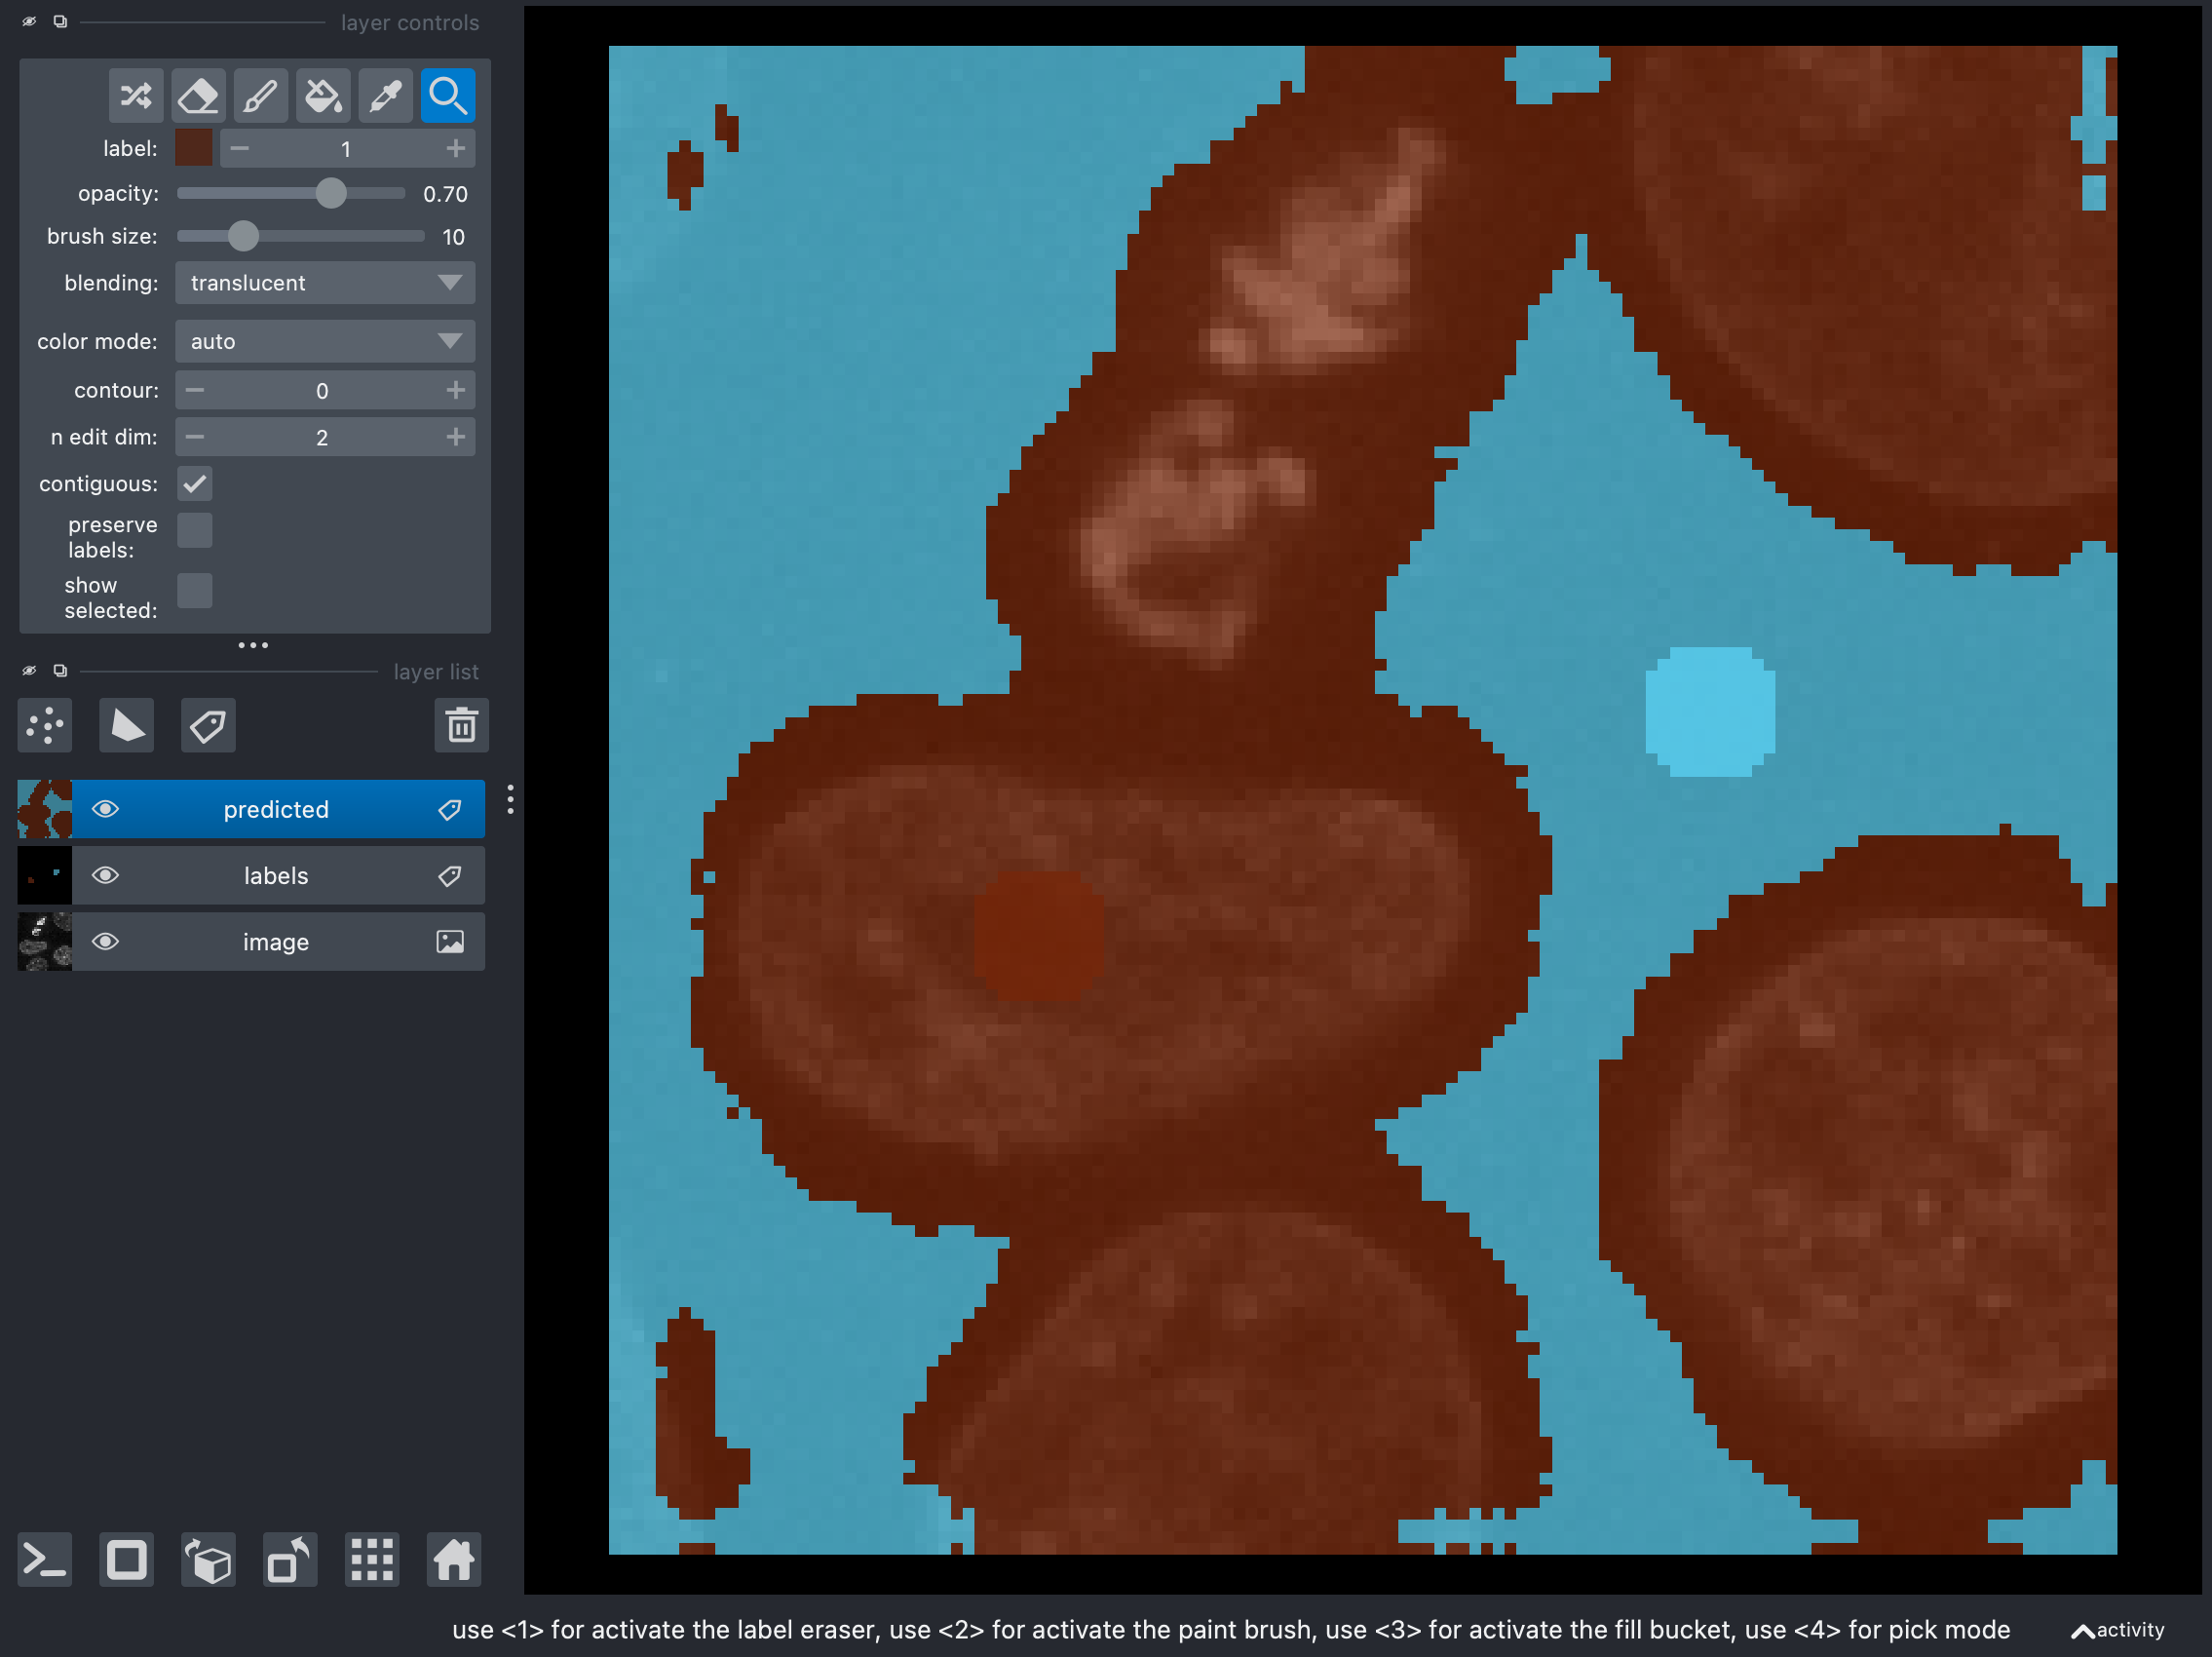

In [17]:
nbscreenshot(viewer)